<img src = "https://www.mvtec.com/fileadmin/_processed_/e/5/csm_mvtec-deep-learning-segmentation-workflow_5b6baf4713.png"></img>
<h1 align='center'> ✈️U-Net Implementation from scratch✈️ </h1>

# Introduction
This notebook will teach you how to implement semantic segmentation(more specifically u-net model) from scratch. This notebook will work as a tutorial for those who have either very less or no idea about semantic segmentation and how to practically implement this on real time dataset. I have implemented this using both Keras and PyTorch. Here I will be using Keras and for PyTorch please refer to my another notebook.<br> 
But before diving into the coding section, first let's understand some theoretical part.

## What is Semantic Segmentation?
Deep learning algorithms have solved several computer vision tasks with an increasing level of difficulty. But the object detection task has exceeded the image classification task in term of complexity as simple deep learning algorithms can’t provide a full comprehension of a scene and they only classify a small part of the information.

The <b>Semantic Segmentation</b> is one of the high-level task that paves the way towards complete scene understanding.

<img src="https://dl.acm.org/cms/attachment/8542befb-3134-46f0-a5ad-1534c63188b4/csur5204-73-f01.jpg"></img>

Semantic segmentation is the task of classifying each and every pixel in an image into a class as shown in the image above. Here you can see that all poles are blue, the trees are green, the road is purple etc.

## Deep Learning Model Architectures for Semantic Segmentation
There are various Deep Learning Model Architectures for Semantic Segmentation which are listed below: - 
1.	Fully Convolutional Network (FCN)
2.	ParseNet
3.	U-Net
4.	Feature Pyramid Network (FPN)
5.	Mask RCNN

And many more....

Here I will talk about U-Net and how to implement that on Aerial Image Dataset.

## U-Net
The U-Net was developed by Olaf Ronneberger et al. for Bio Medical Image Segmentation. The U-Net architecture is built upon the Fully Convolutional Network (FCN) and modified in a way that it yields better segmentation results.<br>
Link for original U-Net paper:- https://arxiv.org/abs/1505.04597<br>
The explaination of the model architecture will come later in this notebook.

### Dataset Description
Let us know about the dataset before going into the coding part.

The dataset is available on Kaggle and the link to download the dataset is :- [Click Here](https://www.kaggle.com/bulentsiyah/semantic-drone-dataset)

The Semantic Drone Dataset focuses on semantic understanding of urban scenes for increasing the safety of autonomous drone flight and landing procedures. The imagery depicts more than 20 houses from nadir (bird's eye) view acquired at an altitude of 5 to 30 meters above ground. A high resolution camera was used to acquire images at a size of 6000x4000px (24Mpx). The training set contains 400 publicly available images. The pixel-accurate annotation for the same training set is also available. The complexity of the dataset is limited to 23 classes.

Now let's dive into the coding section and the first step is to import the necessary libraries.

# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Visualize the data
Next step is to see how our data actually looks like. So our dataset consist of two folders.<br>
One folder contains original images and the another folder contains the label(pixel-accurate annotation) images.<br>
Let's look at starting 3 images of both the folders.

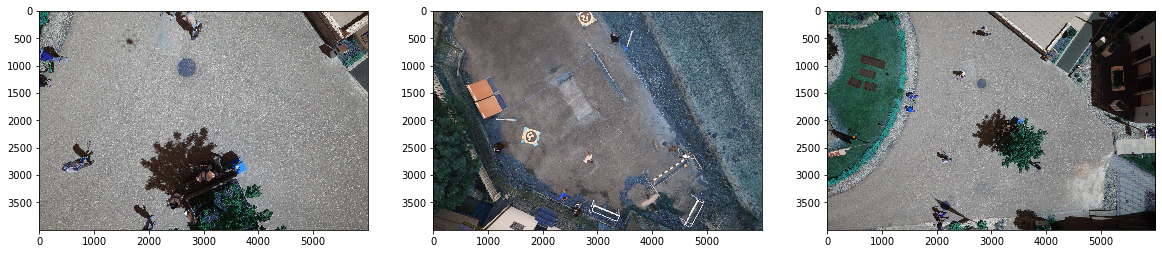

In [2]:
fig = plt.figure(figsize=(20, 20))
for dirname, _, filenames in os.walk('D:/atompy_data/dataset/semantic_drone_dataset/original_images'):
    for i, filename in enumerate(filenames[:3]):
        img = cv2.imread(os.path.join(dirname, filename))
        ax = fig.add_subplot(1, 3, i+1)
        ax.imshow(img)

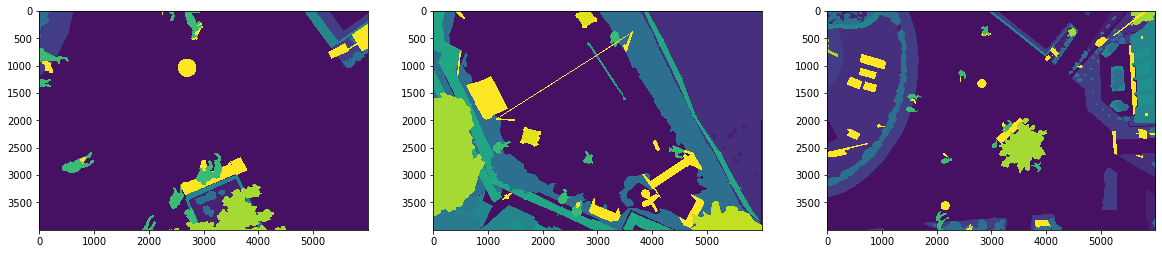

In [3]:
fig = plt.figure(figsize=(20, 20))
for dirname, _, filenames in os.walk('D:/atompy_data/dataset/semantic_drone_dataset/label_images_semantic'):
    for i, filename in enumerate(filenames[:3]):
        img = cv2.imread(os.path.join(dirname, filename), 0)
        ax = fig.add_subplot(1, 3, i+1)
        ax.imshow(img)

# Data Preprocessing

We have basically two folders, one containing the original images and the other containing the labelled images. So we will loop through both the folders and store each and every image in a list. 

In [4]:
img_path = 'D:/atompy_data/dataset/semantic_drone_dataset/original_images'
label_path = 'D:/atompy_data/dataset/semantic_drone_dataset/label_images_semantic'
X = [] # For input images
y = [] # For target images

In [5]:
images = os.listdir(img_path) 
labels = os.listdir(label_path)

# As both the folders contains images randomly so we will sort them so that input and target images are at the same position.
images.sort()
labels.sort()

In [6]:
# small dataset
images = images
labels = labels

So we will loop through the folders. Then we will reduce the dimension of the images and will normalize the image. Afterthat we will append it to the list.

In [7]:
for image in images:
    img1 = cv2.imread(os.path.join(img_path, image))
    img1 = (cv2.resize(img1, (256, 256)))/255
    X.append(img1)

In [8]:
for label in labels:
    img2 = cv2.imread(os.path.join(label_path, label), 0)
    img2 = (cv2.resize(img2, (256, 256)))/255
    y.append(img2)

Let's see one random input and its masked image.

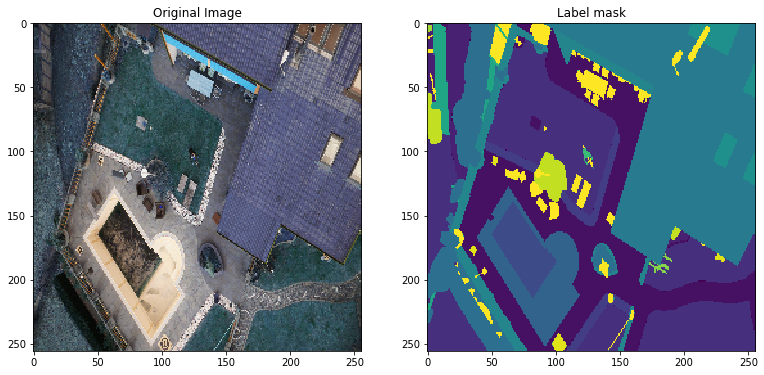

In [9]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1, title='Original Image')
plt.imshow(X[12])

plt.subplot(1, 3, 2, title='Label mask')
plt.imshow(y[12])

Converting list to numpy array

In [10]:
X = np.array(X)
y = np.array(y)

In [11]:
print(X.shape)
print(y.shape)

(400, 256, 256, 3)
(400, 256, 256)


In [12]:
np.unique(y)

array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568627,
       0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
       0.03921569, 0.04313725, 0.04705882, 0.05098039, 0.05490196,
       0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.0745098 ,
       0.07843137, 0.08235294, 0.08627451])

Above you can see that our labels have very random values. So it will be better if we encode them to 0,1,2....<br>
So for that we will use LabelEncoder. But LabelEncoder works on a single vector and right now we have 3 dimensions. So first we will reshape to one dimension. Then we will encode the labels and then will reshape back into the original dimensions.

In [13]:
labelEncoder = LabelEncoder()
n, h, w = y.shape
y_train_reshaped = y.reshape(-1, 1).ravel()
y_train_reshaped_encoded = labelEncoder.fit_transform(y_train_reshaped)
y_train_reshaped_original = y_train_reshaped_encoded.reshape(n, h, w)

In [14]:
np.unique(y_train_reshaped_original)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22], dtype=int64)

In [15]:
num_classes = len(np.unique(y_train_reshaped_original)) 

In [16]:
y_train_reshaped_original = np.expand_dims(y_train_reshaped_original, axis=3)

### Splitting the data into train and test set

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y_train_reshaped_original, test_size=0.2)

### One Hot Encoding

In [18]:
y_train_cat = to_categorical(y_train, num_classes = num_classes)
y_test_cat = to_categorical(y_test, num_classes = num_classes)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

(320, 256, 256, 3)
(80, 256, 256, 3)
(320, 256, 256, 23)
(80, 256, 256, 23)


# U-Net Model
Now it's time to understand the model architecture.<br>
In the original paper, the UNET is described as follows:
<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png"></img>

Firstly as you can see the shape of the architecture is U-shape so the name U-NET. The architecture contains two paths. First path is the contraction path (also called as the encoder) which consists of the repeated application of two 3x3 convolutions followed by a max pooling layer. The second path is the symmetric expanding path (also called as the decoder) which is constituted by transpose 2d convolution layers, a concatenation with the correspondingly cropped feature map from the contracting path followed by two 3x3 convolutions.

Basically the model constitute of 3 different types of layers:-
1.  Convolutional Layer
2.	MaxPooling Layer
3.	Transposed Convolution Layer

For detailed explanation of first two types of layer please refer my another notebook:- [Click Here](https://github.com/Printutcarsh/Digit-Recognizer--Detailed-Explanation-of-CNN/blob/main/digit-recognizer-detailed-explanation-of-cnn.ipynb)

### Transposed Convolution Layer
As stated previously, the output of the model is a complete size image(of the same dimension as the input), so here we can't use our normal dense layers for the output. We need some other technique so that we can get the desired result. Hence there is a need to up sample the image, i.e. convert a low resolution image to a high resolution image. <br>
Although there are many methods to apply upsampling technique but in this model <b>Transposed Convolution Layer</b> is used.

Transposed Convolution Layer performs exactly the opposite of convolution layer and converts a low resolution image to a high resolution image.

Now let's see how to implement this model.<br>
I have implemented the same model architecture with some differences :-
1.  That the shape of my input image is 256x256x3.
2.	And all the convolution layers have 'padding' value 'same'.

First of all as we can observe in both encoder and decoder part at each step there is a stack of two convolution layers. So I have defined a function which consist of two conv2d layers so that I don't have to write these two layers all the time and instead just have to call the function. 

In [20]:
def double_conv(x, n):
    conv = Conv2D(n, (3, 3), activation='relu', padding='same')(x)
    conv = Conv2D(n, (3, 3), activation='relu', padding='same')(conv)
    return conv

Then in the decoder part we can observe that the upconvolution layer output is not directly passed to the other layers. Instead the image from one of the previous double convolution layers is taken and then they are cropped to match the size of the upconvolution and then they are concatenated and afterthat it is passed to other layers. So I have defined a function which takes the image from one of the previous double convolution layer, crop it and then return the cropped image which we can use it to concatenate with the upconvolution layer output image.

In [21]:
def crop_img(down_conv_layer, up_conv_layer):
    up_conv_size = up_conv_layer.shape[1]
    down_conv_size = down_conv_layer.shape[1]
    delta = down_conv_size - up_conv_size
    delta = delta // 2
    return down_conv_layer[:, delta:down_conv_size-delta, delta:down_conv_size-delta, :]

### All the functions are defined and now it's time to build our model.

In [22]:
inputs = Input(shape=(256, 256, 3))

conv1 = double_conv(inputs, 64)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = double_conv(pool1, 128)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = double_conv(pool2, 256)
pool3 = MaxPooling2D((2, 2))(conv3)

conv4 = double_conv(pool3, 512)
pool4 = MaxPooling2D((2, 2))(conv4)

conv5 = double_conv(pool4, 1024)

upcv1 = Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(conv5)
crp1 = crop_img(conv4, upcv1)
upcv1 = Concatenate()([upcv1, crp1])
conv6 = double_conv(upcv1, 512)

upcv2 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(conv6)
crp2 = crop_img(conv3, upcv2)
upcv2 = Concatenate()([upcv2, crp2])
conv7 = double_conv(upcv2, 256)

upcv3 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv7)
crp3 = crop_img(conv2, upcv3)
upcv3 = Concatenate()([upcv3, crp3])
conv8 = double_conv(upcv3, 128)

upcv4 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(conv8)
crp4 = crop_img(conv1, upcv4)
upcv4 = Concatenate()([upcv4, crp4])
conv9 = double_conv(upcv4, 64)

outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

In [23]:
model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [25]:
optimizer = keras.optimizers.Adam(lr=0.0001)

In [26]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### Training the model

In [27]:
model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), batch_size=5, epochs=40)

Epoch 1/40
64/64 [==============================] - 52s 807ms/step - loss: 2.5029 - accuracy: 0.3067 - val_loss: 2.1461 - val_accuracy: 0.3489
Epoch 2/40
64/64 [==============================] - 52s 806ms/step - loss: 2.0964 - accuracy: 0.3842 - val_loss: 2.0127 - val_accuracy: 0.3496
Epoch 3/40
64/64 [==============================] - 52s 811ms/step - loss: 1.9754 - accuracy: 0.4219 - val_loss: 1.8991 - val_accuracy: 0.4998
Epoch 4/40
64/64 [==============================] - 52s 811ms/step - loss: 1.7898 - accuracy: 0.5010 - val_loss: 1.6701 - val_accuracy: 0.5179
Epoch 5/40
64/64 [==============================] - 52s 813ms/step - loss: 1.6753 - accuracy: 0.5183 - val_loss: 1.5604 - val_accuracy: 0.5384
Epoch 6/40
64/64 [==============================] - 52s 814ms/step - loss: 1.6332 - accuracy: 0.5401 - val_loss: 1.5299 - val_accuracy: 0.5548
Epoch 7/40
64/64 [==============================] - 52s 815ms/step - loss: 1.5259 - accuracy: 0.5652 - val_loss: 1.5087 - val_accuracy: 0.5636

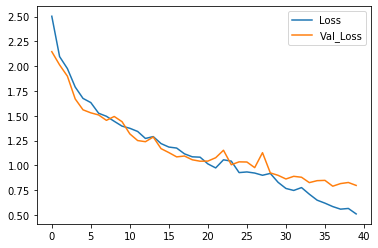

In [29]:
plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.show()

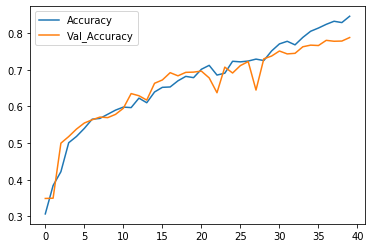

In [30]:
plt.plot(model.history.history['accuracy'], label='Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.show()

# Prediction
Let's see some of our predictions.

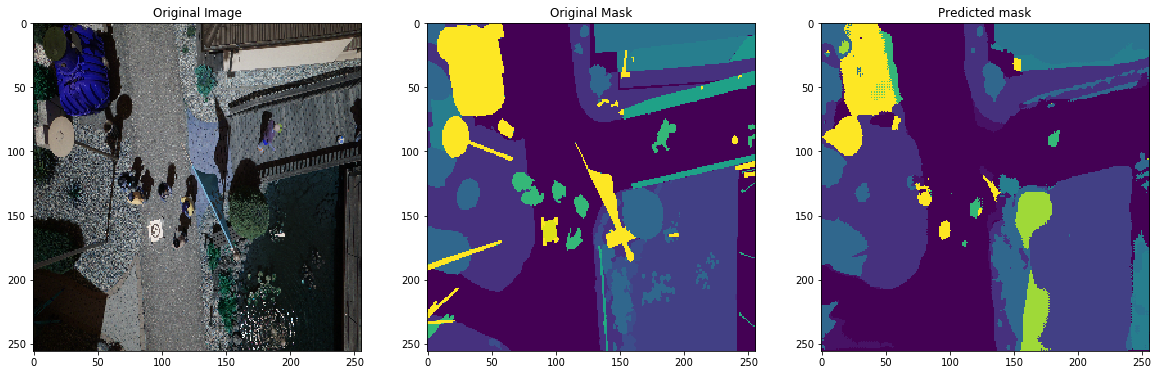

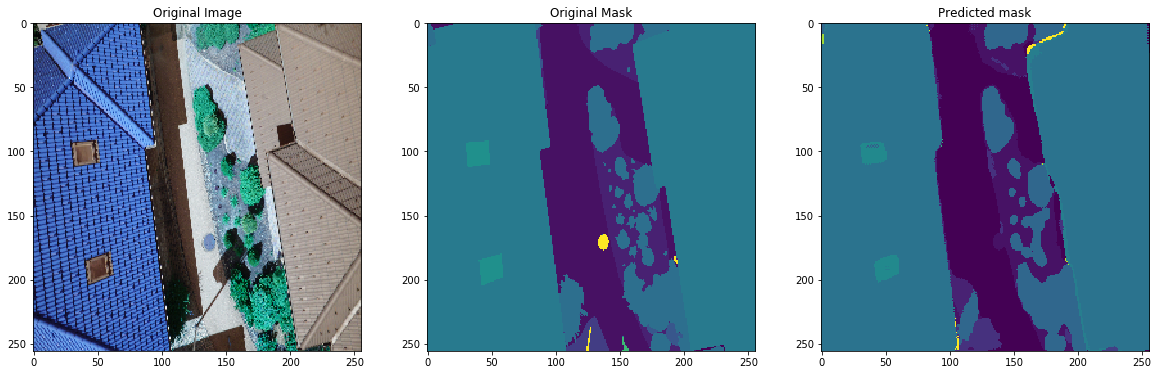

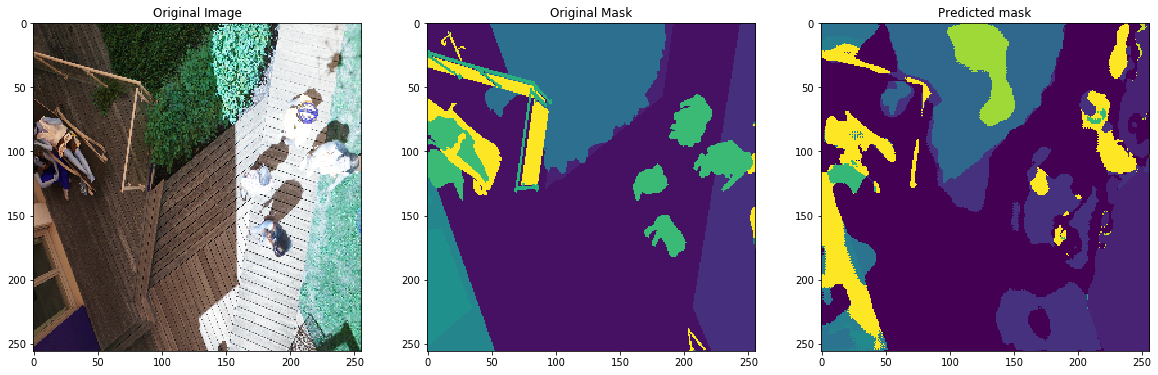

In [31]:
for i in range(3):
    pred = model.predict(X_test[i:i+1, :, :, :])

    pred_arg = np.argmax(pred, axis=3)

    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1, title='Original Image')
    plt.imshow(X_test[i,:,:,:])

    plt.subplot(1, 3, 2, title='Original Mask')
    plt.imshow(np.squeeze(y_test[i,:,:,:], axis=2))

    plt.subplot(1, 3, 3, title='Predicted mask')
    plt.imshow(pred_arg[0])

# Ending Notes
This is all about this notebook. I hope you must have got to know what is Semantic Segmentation and how U-Net works and how it can be implemented.<br> As I already told in this notebook I have implemented using Keras, but if you also want to know how to implement this using PyTorch
<a href="#top" class="btn btn-info btn-lg active" role="button" aria-pressed="true" style="color:white;">Click Here</a>
<br>Thanks a lot for having a look at this notebook. Happy Learning!!